## Постановка задачи. Прогноз спроса на такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
Наша задача подобрать модель, которая наилучшим образом спрогнозирует спрос на такси в следующий час. 
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Подготовка данных

In [3]:
import pandas as pd
import pandas_profiling
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import pickle

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
try:
    df = pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

df.profile_report()

In [5]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


* Данные чистые - пропусков нет. Много нулей, которые означают отсутствие заказов (спроса). Распределение количества заказов околоноральное
* Таймкоды приведем к формату Datetime, проверим на монотонность времени.


In [6]:
df['datetime'] = pd.to_datetime(
    df['datetime'], format='%Y-%m-%dT%H:%M:%S'
)
df = df.set_index('datetime')

In [7]:
df.index.is_monotonic

True

Данные в порядке течения времени. Теперь сделаем ресэпл для одного часа, так как это наш шаг для прогнозирования

In [8]:
df = df.resample('1H').sum()

## Анализ данных

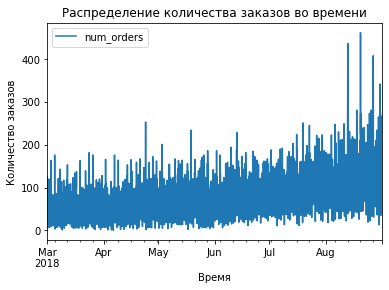

In [9]:
df.plot()
plt.title('Распределение количества заказов во времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')

plt.show()


Не очевидно, но можно уже разглядеть тренд роста. 

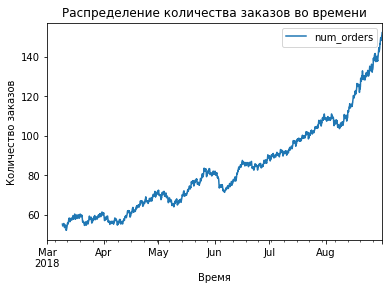

In [10]:
df.rolling(200).mean().plot()

plt.title('Распределение количества заказов во времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')

plt.show()

При оценке движущимся окном, действительно очевиден перманентный рост количества заказов со временем. Также есть нечто похожее на сезонность. Декомпозируем:

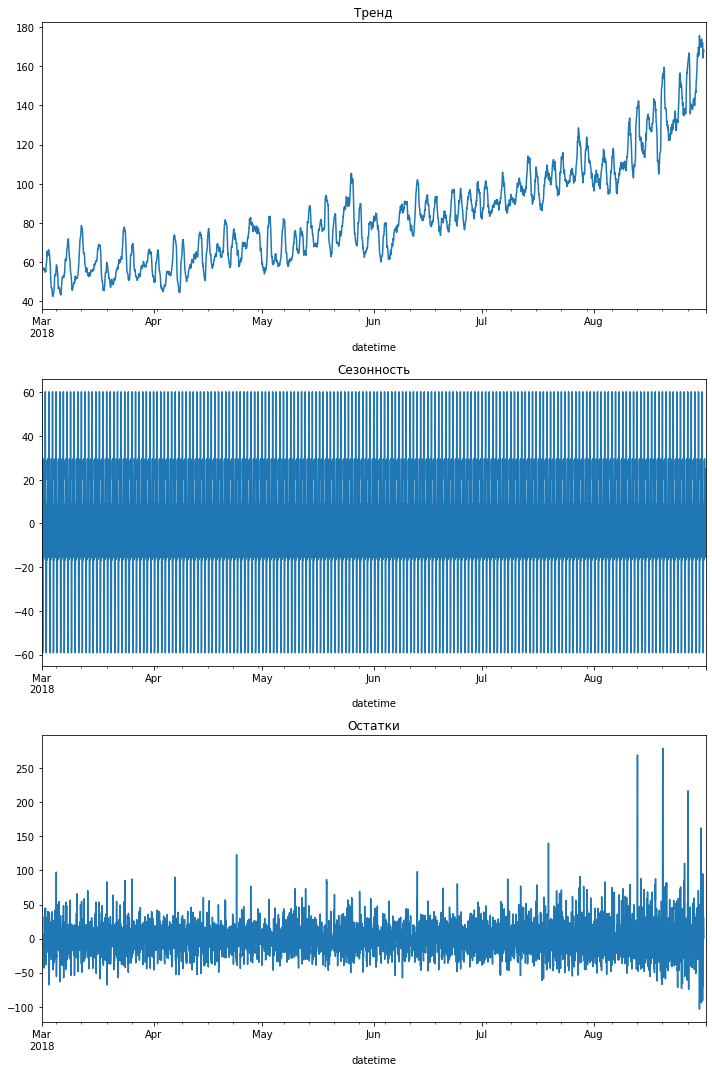

In [11]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Тренд роста подтверждается, а вот сезонность стоит изучить поближе

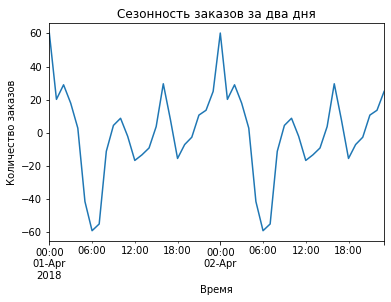

In [12]:
decomposed.seasonal['2018-04-01':'2018-04-02'].plot()

plt.title('Сезонность заказов за два дня')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Видим, что есть выраженная сезонность по времени суток - спад с 00 до 6 утра, затем подъем до пикового значения в 00 часов, когда пробой нет, а общественный транспорт спит

## Подготовка признаков

Признаки будем создавать на базе значений года, месяца, дная и дня недели. Также добавим движущееся среднее с учетом сдвига и непосредственно значения сдвига (lag). Весь процесс поместим в функцию которая на выходе будет отдавать уже готовые признаки 

In [13]:
def featuring(data, max_lag, rolling_mean_size, shifting=False, no_lag=False, no_roll=False, testing=False):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for column in data.columns:
            if 'lag' in column:
                data = data.drop(column, axis=1) 
    
    if shifting == True: 
        data = data - data.shift()
    
    if no_lag == False:
        for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    else:
        for column in data.columns:
            if 'lag' in column:
                data = data.drop(column, axis=1) 
            
    
    if no_roll == False:
        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    else:
        if 'rolling_mean' in data.columns:
                 
            data = data.drop('rolling_mean', axis=1)
    
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train = train.drop(columns=['num_orders'], axis=1)
    features_test = test.drop(columns=['num_orders'], axis=1)
    target_train = train['num_orders']
    target_test = test['num_orders']
    
    
    if testing == True:
        return features_test, target_test
    
    return features_train, target_train

In [15]:
df_day = df.resample('1D').sum()

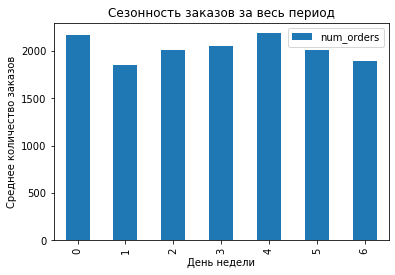

In [16]:
df_day.pivot_table(index=df_day.index.dayofweek, values='num_orders', aggfunc='mean').plot(kind='bar')

plt.title('Сезонность заказов за весь период')
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.show()

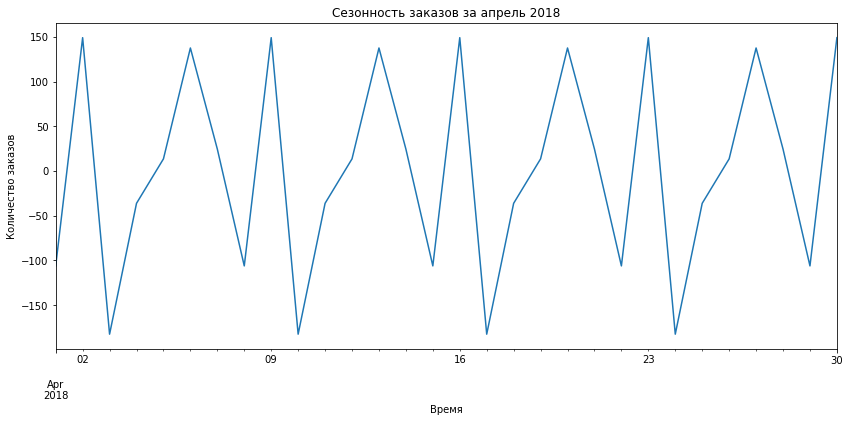

In [17]:
decomposed_day = seasonal_decompose(df_day)
plt.figure(figsize=(14, 6))
decomposed_day.seasonal['2018-04-01':'2018-04-30'].plot()

plt.title('Сезонность заказов за апрель 2018')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Протестируем функцию на случайном наборе параметров

In [18]:
features_train, target_train = featuring(df, 5, 5, shifting=True)

In [19]:
features_train

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,
2018-03-01 06:00:00,0.0,1.0,-37.0,-23.0,-5.0,-14.0,-39.0,-23.6
2018-03-01 07:00:00,0.0,1.0,6.0,-37.0,-23.0,-5.0,-14.0,-14.6
2018-03-01 08:00:00,0.0,1.0,3.0,6.0,-37.0,-23.0,-5.0,-11.2
2018-03-01 09:00:00,0.0,1.0,19.0,3.0,6.0,-37.0,-23.0,-6.4
2018-03-01 10:00:00,0.0,1.0,35.0,19.0,3.0,6.0,-37.0,5.2
...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,0.0,1.0,52.0,-27.0,-17.0,-60.0,-25.0,-15.4
2018-08-13 10:00:00,0.0,1.0,46.0,52.0,-27.0,-17.0,-60.0,-1.2
2018-08-13 11:00:00,0.0,1.0,19.0,46.0,52.0,-27.0,-17.0,14.6


In [20]:
target_train

datetime
2018-03-01 06:00:00     6.0
2018-03-01 07:00:00     3.0
2018-03-01 08:00:00    19.0
2018-03-01 09:00:00    35.0
2018-03-01 10:00:00    -5.0
                       ... 
2018-08-13 09:00:00    46.0
2018-08-13 10:00:00    19.0
2018-08-13 11:00:00   -12.0
2018-08-13 12:00:00   -52.0
2018-08-13 13:00:00    27.0
Freq: H, Name: num_orders, Length: 3968, dtype: float64

In [21]:
model = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model,features_train, target_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

Значение метрики RMSE на обучающей выборке для LinearRegression -32.308558177429894


Получили первое измерение RMSE, которое подходит под критерий задачи, но только если можель повторит это значение на тестовой выборке. Попробуем улучшить показатель перебором параметров для нашей функции создания фич:

In [22]:
def featuring_search(data, model, feat=False):
    best_score  = 100
    best_lag = 0
    best_rolling_size = 0
    best_shift = None
    best_model = None
    
    for n_l in [True, False]:
        for n_r in [True, False]:
            for l in range(1,2):
                for r in [1, 24, 48]:
                    for s in [True, False]:

                        features_train, target_train = featuring(
                            data=data, max_lag=l, rolling_mean_size=r, shifting=s, no_lag=n_l, no_roll=n_r,
                        )

                        rmse = -1*cross_val_score(model, features_train, target_train, 
                                 cv = TimeSeriesSplit(n_splits=8), 
                                 n_jobs = -1, 
                                 scoring = 'neg_root_mean_squared_error').mean()
                        print(rmse)

                        if rmse < best_score:
                            best_score = rmse
                            if n_l == False:
                                best_lag = l
                            else:
                                best_lag = 'no_lag'
                            if n_r == False:
                                best_rolling_size = r
                            else:
                                best_rolling_size = 'no_roll'
                            print('!!!', rmse)    
                            best_shift = s
                            best_model = model
                            features_train_final = features_train
                            target_train_final = target_train
                            
    print(
        'лучший RMSE:{} достигнут на следующих параметрах\n lag: {}\n rolling_size: {}\n shifting: {}\n'
        .format(best_score, best_lag, best_rolling_size, best_shift)
    )
    if feat == True:
        return model.fit(features_train_final, target_train_final), features_train_final, target_train_final
    return model.fit(features_train_final, target_train_final)

In [23]:
%%time
lin_model = featuring_search(df, LinearRegression())

35.879640732000105
!!! 35.879640732000105
39.53191348755582
35.879640732000105
39.53191348755582
35.879640732000105
39.53191348755582
34.054091636200255
!!! 34.054091636200255
32.40570797446263
!!! 32.40570797446263
33.74257525752485
35.03107540347396
33.561025716482774
35.106875913097795
34.054091636200255
32.40570797446263
34.054091636200255
32.40570797446263
34.054091636200255
32.40570797446263
34.070220404372435
32.411394951146214
32.882053002541994
31.366763577025022
!!! 31.366763577025022
32.81692410676905
31.333038948367303
!!! 31.333038948367303
лучший RMSE:31.333038948367303 достигнут на следующих параметрах
 lag: 1
 rolling_size: 48
 shifting: False

CPU times: total: 609 ms
Wall time: 603 ms


In [24]:
%%time
lasso_model = featuring_search(df, Lasso())

35.86602719775871
!!! 35.86602719775871
39.50115703426928
35.86602719775871
39.50115703426928
35.86602719775871
39.50115703426928
34.07120325631135
!!! 34.07120325631135
32.39553669346283
!!! 32.39553669346283
33.83807831369005
35.02386822285733
33.7247953162324
35.13414024534486
34.07120325631135
32.39553669346283
34.07120325631135
32.39553669346283
34.07120325631135
32.39553669346283
34.07120325631135
32.39553669346283
32.99606390501916
31.367480833263386
!!! 31.367480833263386
33.005801043503496
31.344726617564532
!!! 31.344726617564532
лучший RMSE:31.344726617564532 достигнут на следующих параметрах
 lag: 1
 rolling_size: 48
 shifting: False

CPU times: total: 1 s
Wall time: 590 ms


Улучшили показатель больше чем на три пункта. Попробуем другие модели и выберем лучшую:

In [25]:
%%time
gbm_model, gbm_features, gbm_target = featuring_search(df, LGBMRegressor(random_state=123456), feat=True)

35.86768978481175
!!! 35.86768978481175
30.053484604867634
!!! 30.053484604867634
35.86768978481175
30.053484604867634
35.86768978481175
30.053484604867634
34.19934292857838
28.310270884126158
!!! 28.310270884126158
34.04029210881407
24.402165803369538
!!! 24.402165803369538
33.635061490866654
24.629596055530072
34.19934292857838
28.310270884126158
34.19934292857838
28.310270884126158
34.19934292857838
28.310270884126158
34.19934292857838
28.310270884126158
33.72636370902915
24.85256040439829
33.31097259115909
25.139650125819102
лучший RMSE:24.402165803369538 достигнут на следующих параметрах
 lag: no_lag
 rolling_size: 24
 shifting: False

CPU times: total: 812 ms
Wall time: 3.04 s


In [26]:
def gbm_hyp(data, model=None):

    objective = ['Regression_l1', 'Regression']
    num_leaves = [int(x) for x in np.linspace(start = 10, stop = 100, num = 20)]
    
    grid = {
        'objective': objective,
        'num_leaves': num_leaves,
    }  
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions = grid,
        n_iter=25, cv=4, verbose=0, random_state=35, n_jobs = -1,
        scoring='neg_root_mean_squared_error',
        
    )
    
    search.fit(data, gbm_target)
    final_model = search.best_estimator_

    print (
        'Лучшие параметры:', search.best_params_,'\n',
        'RMSE', search.best_score_,'\n'
    )  
        
    return final_model

In [27]:
%%time
gbm_best = gbm_hyp(gbm_features, gbm_model)

Лучшие параметры: {'objective': 'Regression', 'num_leaves': 14} 
 RMSE -24.13169717566926 

CPU times: total: 422 ms
Wall time: 1.2 s


* Следующий код выполняется около 3,5 часов и намеренно закомментирован. Ниже приложил скриншот результата отработки ячейки и представил (также закомментированный) код записи файла с моделью и фичами. Чтение из файла и ссылка на диск с файлом прилагаются.

In [36]:
%%time
#forest_model, features_forest, target_forest = featuring_search(df, RandomForestRegressor(random_state=123456), feat=True)
print(f'''Значение метрики RMSE на обучающей выборке для Случайного леса''', cross_val_score(model, features_forest, target_forest, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

35.878609413032805
!!! 35.878609413032805
30.31554679390807
!!! 30.31554679390807
35.878609413032805
30.31554679390807
35.878609413032805
30.31554679390807
34.982022307133484
28.996995639880282
!!! 28.996995639880282
34.76565673759329
25.228578140375692
!!! 25.228578140375692
34.27984602228233
25.254759509396067
34.982022307133484
28.996995639880282
34.982022307133484
28.996995639880282
34.982022307133484
28.996995639880282
34.98216941707095
29.014038008421316
34.87478047473779
25.06640790862333
!!! 25.06640790862333
34.86114006148881
25.11745957503026
лучший RMSE:25.06640790862333 достигнут на следующих параметрах
 lag: 1
 rolling_size: 24
 shifting: False

Значение метрики RMSE на обучающей выборке для Случайного леса -31.366763577025022
CPU times: total: 1.34 s
Wall time: 13.2 s


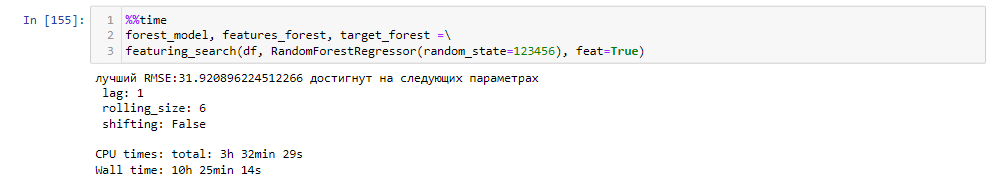

In [29]:
forest_model_settings = "forest_model_settings.pkl"

In [30]:
#tuple_settings = forest_model, features_forest, target_forest

#with open(forest_model_settings, 'wb') as file:
#    pickle.dump(tuple_settings, file)

тупл с моделью, таргетом и фичами https://disk.yandex.ru/d/BvtP1byvR9Z2pQ

In [31]:
with open(forest_model_settings, 'rb') as file:
    forest_model, features_forest, target_forest = pickle.load(file)

Случайный лес подбирал параметры 3,5 часа, но итоговая модель оказалась лучшей! Попробуем еще улучшить результат случайным подбором гиперпараметров:

In [37]:
%%time
    
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 30)]
min_samples_split = [2, 6, 12, 15]
min_samples_leaf = [1, 3, 4, 6]

grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}  

search = RandomizedSearchCV(
    estimator=forest_model,
    param_distributions = grid,
    n_iter=10, cv=None, verbose=4, random_state=35, n_jobs = -1,
    scoring='neg_root_mean_squared_error'

)

search.fit(features_forest, target_forest)
final_forest_model = search.best_estimator_

print (
    'Лучшие параметры:', search.best_params_,'\n',
    'RMSE', search.best_score_,'\n'
)  



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 21} 
 RMSE -24.67232747121947 

CPU times: total: 1.14 s
Wall time: 6.48 s


Успех! RMSE самая низкая - 22. Удалось сократить значение ошибки почти на 10 пунктов. Соберем все данные в таблицу:

| Модель| RMSE | 
| --- | --- | 
| Случайный Лес(Ordinal) | 32.9 |
| LGBM | 35 |
| Линейная регрессия | 33.7 | 
| CatBoost | 33.3 | 

In [33]:
cat_model, cat_features_train, cat_target_train =\
featuring_search(df, CatBoostRegressor(random_state = 1234, verbose = False), feat=True)

parametrs = {'depth' : range(1, 5, 1),
                'iterations' : range(100, 500, 100)
               }
my_cv=TimeSeriesSplit(n_splits=8).split(cat_features_train)
grid = GridSearchCV(cat_model, parametrs, cv=my_cv, scoring='neg_root_mean_squared_error')
grid.fit(cat_features_train, cat_target_train)

grid.best_score_
cat_model = grid.best_estimator_

35.879640731715114
!!! 35.879640731715114
30.206629167048604
!!! 30.206629167048604
35.879640731715114
30.206629167048604
35.879640731715114
30.206629167048604
34.41407939581365
28.106081170802604
!!! 28.106081170802604
34.269129663645
25.00768985357945
!!! 25.00768985357945
33.617386683251155
25.893231475952874
34.41407939581365
28.106081170802604
34.41407939581365
28.106081170802604
34.41407939581365
28.106081170802604
34.428773790758356
28.12077320347892
33.26987882372601
24.569291430565844
!!! 24.569291430565844
33.2370307250443
25.369024885006105
лучший RMSE:24.569291430565844 достигнут на следующих параметрах
 lag: 1
 rolling_size: 24
 shifting: False



## Проверка модели

Достанем тестовую выборку

In [39]:
features_test, target_test =\
featuring(df, max_lag=1, rolling_mean_size=24, shifting=False, testing=True)

In [43]:
predict = cat_model.predict(features_test)
mean_squared_error(target_test, predict, squared=False)

45.57362995075806

In [44]:
summerize = pd.DataFrame(index=target_test.index, data=predict, columns=['Пердсказанные'])
summerize['Реальные'] = target_test

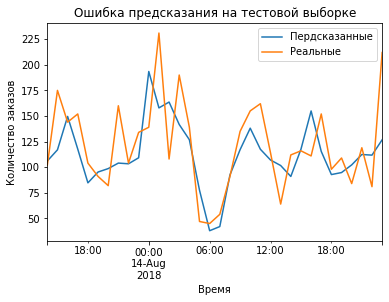

In [45]:
summerize['2018-08-13':'2018-08-14'].plot()
plt.title('Ошибка предсказания на тестовой выборке')
plt.xlabel('Время')
plt.ylabel('Количество заказов')

plt.show()

Ошибка больше чем в два раза привышает значения на тренировочном датасете, но это значение нас устраивает, так как оно не должно привышать 48. Сравним с базовой моделью при расчете среднего для таргета:

In [46]:
pred_mean = np.ones(target_test.shape) * target_train.mean()
mean_squared_error(target_test, pred_mean, squared=False)

151.3147143365469

и при при прогнозе предидущим значением:

In [47]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
mean_squared_error(target_test, pred_previous, squared=False)

58.95895496903523

результаты нашей модели на случайном лесе лучше чем результаты базовой модели.

# Выводы

В результате работы удалось дотичь нужного значения метрики RMSE при прогонозе спроса на такси в следующий час. В нашем проекте это значение на тестовой выборке составило 46,3 для выбранной модели случайного леса с подобранными гиперпараметрами, которая показала себя на тестововй выборке лучше LGBM и Линейная регрессия. Также, на первых этапах работы был проведен анализ данных, в рамках которого выявлен тренд к росту спроса на таки на всем датасете и явная сезонность связанная с ростом спровс в ночные часы, спадом в утренние и средним значением днем. 